In [1]:
import sys

print(sys.version)

3.10.12 | packaged by Anaconda, Inc. | (main, Jul  5 2023, 19:01:18) [MSC v.1916 64 bit (AMD64)]


In [2]:
import torch

## Importing the dependencies

In [1]:
import easyocr
import imutils
import matplotlib.pyplot as plt
import cv2
import numpy as np 

## Read in image, grayscale and blur

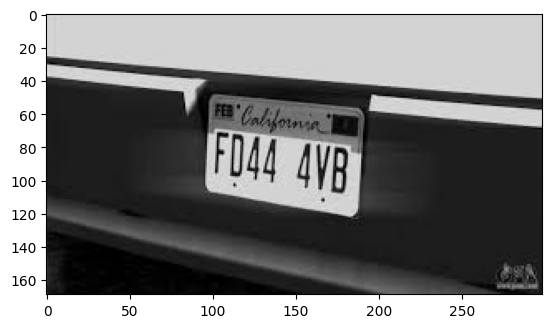

In [530]:
# for reading the image
img = cv2.imread("images/img3.jpeg")

# changing the image to grayscale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# by default the matplotlib wants the image in rgb and hence this command for proper conversion into RGB
plt.imshow(cv2.cvtColor(gray,cv2.COLOR_BGR2RGB));

## Apply filter and find edges for localisation

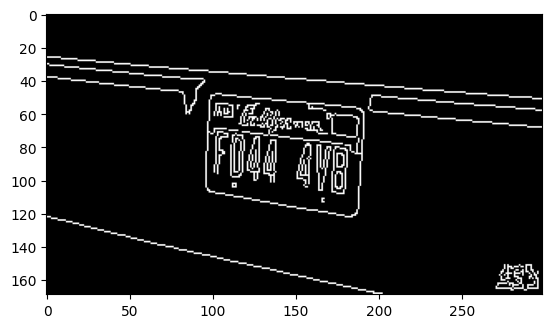

In [531]:
# for noise reduction
# 11 17 17 -> parameters for specifying how much intensly we want noise reduction
bfilter = cv2.bilateralFilter(gray, 10, 17, 17)

# for edge detection
edged = cv2.Canny(bfilter, 20, 300)

plt.imshow(cv2.cvtColor(edged,cv2.COLOR_BGR2RGB));

## Find contours and apply mask

In [532]:
# this actually finds the shapes in the edged image above 
# 1st parameter -> sent the edged copy
# 2ns parameter -> it specifies the result format in which form we want the result (Here it is tree)
# 3rd parameter -> what type of results should be returned (for ex if it is a line then dont return
# every point on the line but simplified version of that shape here it would be keypoints)
# for number plate we should get the 4 points that represent the rectangle 
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# it simplifies how are contours are to be returned
contours = imutils.grab_contours(keypoints)

# this sorts the contours and returns the top 10 shapes 
# sorting is done using the area and we are reversing the list means it is returning in the descending order
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [533]:
location = None
location_store = []
for contour in contours:
    # 2nd parameter -> specifies how much roughly you want that shape to be
    # 3rd parameter -> closed polygon - true
    approx = cv2.approxPolyDP(contour, 10, True)
    # if that approx contour is having 4 contours then mostly it would be our number plate
    if len(approx) == 4:
        location_store.append(approx)
        
approx = location_store[0]
# location
location_store

[array([[[ 99,  49]],
 
        [[ 98, 107]],
 
        [[187, 120]],
 
        [[189,  57]]], dtype=int32),
 array([[[ 99,  50]],
 
        [[188,  57]],
 
        [[187, 119]],
 
        [[ 99, 107]]], dtype=int32)]

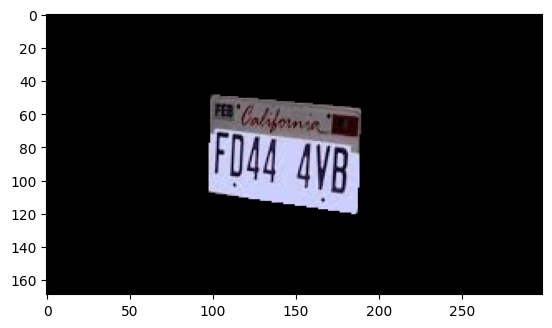

In [534]:
# this masks out that much area out of that image fills the remaining area with blank zeros
mask = np.zeros(gray.shape, np.uint8)

# here we are drawing that particular image and passing the coordinates and coloring it with which color
new_img = cv2.drawContours(mask, [location_store[0]], 0, 255, -1)

# printing the cut out image
new_img = cv2.bitwise_and(img, img, mask=mask)

plt.imshow(cv2.cvtColor(new_img,cv2.COLOR_BGR2RGB))

In [535]:
# grabbing the coordinates where the region is not black
(x,y) = np.where(mask==255)

# here we are storing the 2 cross coordinates for drawing that section
(x1,y1) = (np.min(x), np.min(y))
(x2,y2) = (np.max(x), np.max(y))

# the image drawing from x1 to x2 then y1 to y2
# +1 is for buffer
cropped_img = gray[x1:x2+1,y1:y2+1]

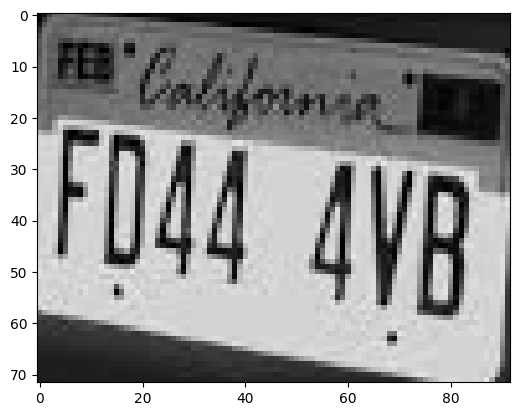

In [536]:
plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))

## Use easy ocr to read text

In [537]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_img)
result

[([[3, 3], [65, 3], [65, 23], [3, 23]], 'FE" Vabito:,', 0.04474283290361006),
 ([[0, 18], [92, 18], [92, 66], [0, 66]], 'FD44 4VB ', 0.4888006929683184)]

## Render Result

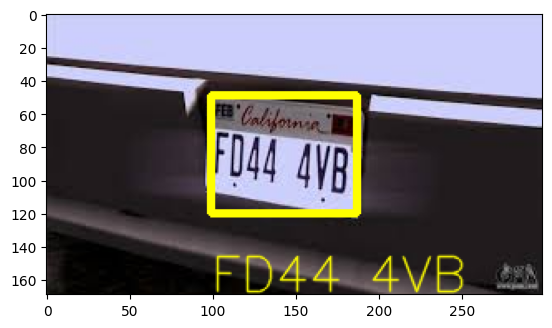

In [541]:
text = result[1][-2]
font = cv2.FONT_HERSHEY_SIMPLEX
img = cv2.imread("images/img3.jpeg")
res = cv2.putText(img,text=text,org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=(0,255,255), thickness=1, lineType=cv2.LINE_AA)
res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,255),3)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB));